<a href="https://colab.research.google.com/github/knight19720208ui/AI/blob/main/K_means01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **K-means** es uno de los algoritmos de aprendizaje automático no supervisado más popular. El objetivo de k-means es simple: agrupa puntos de datos similares con el objetivo de descubrir patrones subyacentes. Para lograr este objetivo, k-means busca un número fijo (k) de agrupamientos (clústers) en el conjunto de datos.


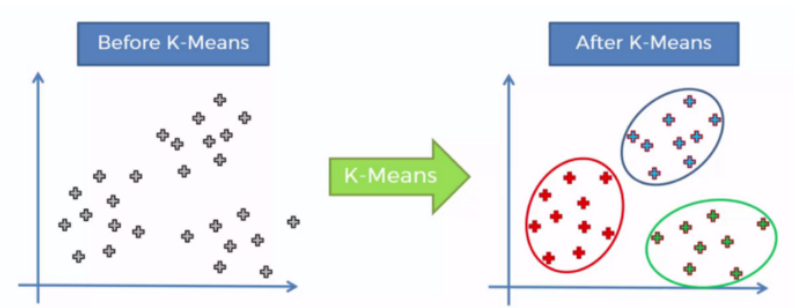

In [3]:
from IPython.display import Image
Image("kmeans.PNG")

Así pues, el algoritmo Kmeans consta de los siguientes puntos:

Inicializamos k centroides de forma aleatoria.

1.   Inicializamos k centroides de forma aleatoria.
2.   Calcular la suma de desviaciones al cuadrado (o su raíz).
3.   Asignar un centroide a cada una de las observaciones.
4.   Calcular el error total y compararla con la suma en la anterior iteración.
5.   Si disminuye el error, recalcular centroides y repetir el proceso.

Como se ve, a nivel conceptual es un algoritmo muy sencillo, aunque verás cómo vamos a encontrarnos unos puntos más complicados. En cualquier caso, para ver cómo funciona, primero necesitaremos unos datos sobre los que usar el algoritmo kmeans en Python.

**Creación de datos ficticios**

Así pues, vamos a crear unos datos ficticios muy diferenciados para tres grupos, al igual que hizo en el de regresión.

Para ello, vamos a crear una función que, dadas unas coordenadas, un radio y un número de datos, creará esa cantidad de datos distribuidos de forma aleatoria alrededor del centro elegido.

De esta forma, crearemos tres grupos diferenciados en los que, puede ser que datos de diferentes grupos estén cerca, pudiendo dar así lugar a ciertos errores.

In [4]:
import math
import numpy as np
import pandas as pd
np.random.seed(123)

def circulo(num_datos = 100,R = 1, minimo = 0,maximo= 1, 
            center_x = 0 , center_y = 0):
    pi = math.pi
    r = R * np.sqrt(np.random.uniform(minimo, maximo, size = num_datos)) 
    theta = np.random.uniform(minimo, maximo, size= num_datos) * 2 * pi

    x = center_x + np.cos(theta) * r
    y = center_y + np.sin(theta) * r

    x = np.round(x,3)
    y = np.round(y,3)

    df = np.column_stack([x,y])
    df = pd.DataFrame(df)
    df.columns = ['x','y']
    return(df)

# Create data
datos_1 = circulo(num_datos = 20,R = 10, center_x = 5, center_y = 30)
datos_2 = circulo(num_datos = 20,R = 10, center_x = 20, center_y = 10)
datos_3 = circulo(num_datos = 20,R = 10, center_x = 50, center_y = 50)

data = datos_1.append(datos_2).append(datos_3)
data.head()

,x,y
0,-0.542,23.761
1,8.129,25.661
2,4.239,25.298
3,-0.691,25.230
4,3.539,21.645


**Veamos con se distribuyen**:

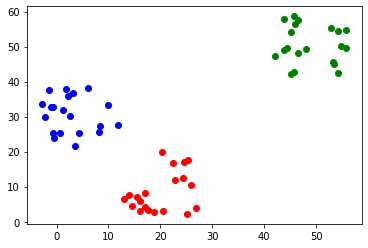

In [6]:
import matplotlib.pyplot as plt
# %matplotlib inline

plt.scatter(datos_1['x'], datos_1['y'], c = 'b')
plt.scatter(datos_2['x'], datos_2['y'], c = 'r')
plt.scatter(datos_3['x'], datos_3['y'], c = 'g')
plt.show()

In [7]:
"""
A desarrollar el algoritmo desde cero:
"""

# Inicializamos los k centroides de forma aleatoria

def initialize_centroids(k, data):

    n_dims = data.shape[1]
    centroid_min = data.min().min()
    centroid_max = data.max().max()
    centroids = []

    for centroid in range(k):
        centroid = np.random.uniform(centroid_min, centroid_max, n_dims)
        centroids.append(centroid)

    centroids = pd.DataFrame(centroids, columns = data.columns)

    return centroids

centroids = initialize_centroids(3, data)
centroids


,x,y
0,52.833388,9.953092
1,15.168107,29.151304
2,52.622571,57.644971


In [9]:
# Calcular la suma de errores al cuadrado

def calculate_error(a,b):
    '''
     Dados dos matrices Numpy, calcular la raiz de la suma de los errores
     al cuadrado.
    '''
    error = np.square(np.sum((a-b)**2))
    return error  

In [10]:
"""
Como ya tenemos los centroides, los datos y la forma de calcular el error, 
podemos comprobar que nuestro error funciona correctamente. Para ello 
simplemente debemos obtener los errores de los 3 centroides a una observación 
y compararlo visualmente:
"""
errors = np.array([])
for centroid in range(centroids.shape[0]):
    error = calculate_error(centroids.iloc[centroid, :2], data.iloc[0,:2])
    errors = np.append(errors, error)

errors


array([ 9239109.47028511,    76100.30291143, 15797406.01662303])

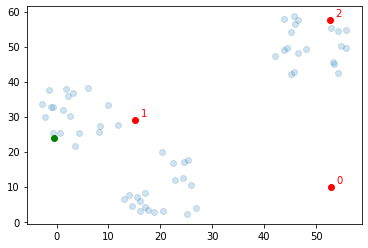

In [11]:
'''
Como vemos, según los datos, el segundo centroide (índice 1) es el que 
más cerca está de nuestros datos. Vamos a comprobarlo visualmente:
'''

plt.scatter(data.iloc[1:,0], data.iloc[1:,1],  marker = 'o', alpha = 0.2)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', c = 'r')
plt.scatter(data.iloc[0,0], data.iloc[0,1],  marker = 'o', c = 'g')
for i in range(centroids.shape[0]):
    plt.text(centroids.iloc[i,0]+1, centroids.iloc[i,1]+1, s = centroids.index[i], c = 'r')

In [12]:
# Asignar un centroide a cada una de las observaciones

np.where(errors == np.amin(errors))[0].tolist()[0]

1

In [13]:
'''
Así pues, debemos aplicar este mismo proceso a todas las observaciones. 
Como será algo recurrente, lo mejor será definirlo como una función.
'''
def assign_centroid(data, centroids):
    '''
    Receives a dataframe of data and centroids and returns a list assigning each observation a centroid.
    data: a dataframe with all data that will be used.
    centroids: a dataframe with the centroids. For assignment the index will be used.
    '''

    n_observations = data.shape[0]
    centroid_assign = []
    centroid_errors = []
    k = centroids.shape[0]


    for observation in range(n_observations):

        # Calculate the errror
        errors = np.array([])
        for centroid in range(k):
            error = calculate_error(centroids.iloc[centroid, :2], data.iloc[observation,:2])
            errors = np.append(errors, error)

        # Calculate closest centroid & error 
        closest_centroid =  np.where(errors == np.amin(errors))[0].tolist()[0]
        centroid_error = np.amin(errors)

        # Assign values to lists
        centroid_assign.append(closest_centroid)
        centroid_errors.append(centroid_error)

    return (centroid_assign,centroid_errors)

data['centroid'], data['error'] = assign_centroid(data.iloc[:,:2] ,centroids)
data[['centroid', 'error']].head()


,centroid,error
0,1,76100.302911
1,1,3810.746835
2,1,18034.697838
3,1,71229.148068
4,1,36703.174251


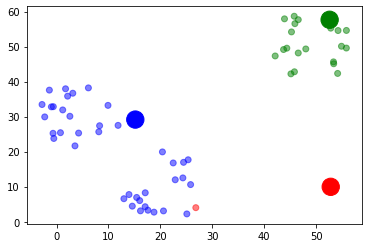

In [14]:
'''
Ahora que ya tenemos la asignación realizada, podemos comprobar visualmente 
cómo ha quedado esta asignación:
'''

colors = {0:'red', 1:'blue', 2:'green'}

plt.scatter(data.iloc[:,0], data.iloc[:,1],  marker = 'o', 
            c = data['centroid'].apply(lambda x: colors[x]), alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', s=300, 
           c = centroids.index.map(lambda x: colors[x]))

In [15]:
# Calcular la suma de errores total

'''
Calcular la suma de errores total es algo muy sencillo. Como ya hemos 
guardado el error de la operación en una columna, simplemente hacer la suma 
de los errores nos dará la uma de errores total:
'''
data['error'].sum()

7089622.406081449

In [16]:
'''
Esta suma deberemos compararla con el resultado de la iteración anterior. 
En nuestro caso, se trata de la primera iteración por lo que siempre vamos 
a seguir.

Asimismo, comentar que generalmente la coincidencia con el error anterior 
debe ser exacta. Esto significaría que nuestros centroides no se han movido, 
puesto que han llegado a un punto que minimiza el error.
'''

# Recalcular la posición de los centroides

'''
Si el punto anterior no se ha cumplido, es decir, si el error total ha 
disminuido, deberemos recalcular la posición de los centroides para repetir 
el proceso. Para recalcular los centroides simplemente debemos calcular la 
posición media del centroide como una media de sus variables.
'''
data_columns = ['x','y']

centroids = data.groupby('centroid').agg('mean').loc[:,data_columns].reset_index(drop = True)
centroids


,x,y
0,26.831000,4.002000
1,10.902256,19.928974
2,48.898800,50.526050


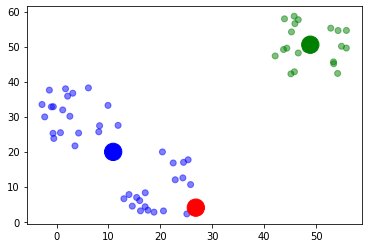

In [17]:
'''
 Al volver a visualizar los datos, veremos como los centroides han cambiado 
 su posición, situándose en el centro de los datos:
'''

plt.scatter(data.iloc[:,0], data.iloc[:,1],  marker = 'o', 
            c = data['centroid'].apply(lambda x: colors[x]), alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', s=300, 
           c = centroids.index.map(lambda x: colors[x]))

In [ ]:
'''
Ahora que tenemos los centroides recalculados, deberíamos repetir el 
proceso anterior, hasta que el error no disminuya más.
'''